In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import SVD, SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np

1.Датасет ml-latest

In [ ]:
links = pd.read_csv('/content/links.csv')
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')

2.Вспомнить подходы, которые мы разбирали

1. в первом дз (dz_recomm_sys_01) использовалась регрессия на фичах
tf-IDF на тегах и жанрах.(LinearRegression() и Lasso()).
лучшая ско достиглась на лассо с добавлением средней оценки пользователя 
=>

0.4021898295629839
0.3728928435223492

2. во втором (dz_collab_filter.ipynb)
из пакета surprise
на лекции knn:

=>(array([0.90135358, 0.90952593, 0.89215762, 0.90486007, 0.90461681]),
 0.9025027998620349)

 в дз пробывала SVD,SlopeOne SVDpp

 лучшим оказался последний СКО: 
 
=>(array([0.86008059, 0.86752488, 0.85145706, 0.8627509 , 0.86023119]),
 0.8604089225494835)

 3. на лекции по гибридным LightFM
=> Precision: train 0.61, test 0.23.


In [ ]:
movies_with_ratings = movies.join(ratings.set_index('movieId'), on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,3.0,8.518667e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9.0,4.0,9.386292e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13.0,5.0,1.331380e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.0,9.979383e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,8.551901e+08


In [ ]:
dataset = pd.DataFrame({
    'uid': movies_with_ratings.userId,
    'iid': movies_with_ratings.title,
    'rating': movies_with_ratings.rating
})
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(dataset, reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.15, random_state=42)

In [ ]:
# модель 1
algo = SVD(n_factors=20, n_epochs=20)
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8845


0.8845262851931808

In [ ]:
algo.predict(uid=2.0, iid='Mortal Kombat (1995)').est

2.80049714966149

In [ ]:
current_user_id = 2.0
user_movies = movies_with_ratings[movies_with_ratings.userId == current_user_id].title.unique()

scores = []
titles = []

for movie in movies_with_ratings.title.unique():
    if movie in user_movies:
        continue
        
    scores.append(algo.predict(uid=current_user_id, iid=movie).est)
    titles.append(movie)

In [ ]:
sorted(scores)[-10:]

[4.2824854854671175,
 4.287073296085373,
 4.292235969711947,
 4.301762486121787,
 4.303585675444584,
 4.35897027114473,
 4.37298876613775,
 4.378498160731505,
 4.38281555935352,
 4.434585307506802]

In [ ]:
# выход 1
titles = np.array(titles)
titles[np.argsort(-np.array(scores))[:5]]

array(['African Queen, The (1951)', 'Band of Brothers (2001)',
       'Godfather: Part II, The (1974)', 'Godfather, The (1972)',
       'Shawshank Redemption, The (1994)'], dtype='<U158')

In [ ]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))
movie_genres = [change_string(g) for g in movies.genres.values]
movie_genres[0]

'Adventure Animation Children Comedy Fantasy'

In [ ]:
# модель 2
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

neigh = NearestNeighbors(n_neighbors=20, n_jobs=-1, metric='euclidean') 
neigh.fit(X_train_tfidf)

NearestNeighbors(metric='euclidean', n_jobs=-1, n_neighbors=20)

In [ ]:
test = change_string("Adventure|Comedy|Fantasy|Crime")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [ ]:
res

(array([[0.42697878, 0.53455477, 0.53455477, 0.53455477, 0.53455477,
         0.53455477, 0.53455477, 0.53455477, 0.53455477, 0.53455477,
         0.53455477, 0.53455477, 0.53455477, 0.53455477, 0.61206304,
         0.63362962, 0.63362962, 0.63362962, 0.63362962, 0.64824951]]),
 array([[6982, 5894,  912, 3611, 3815, 8038, 3819, 7700, 3524, 2453, 2784,
         5991, 8522, 6927, 6497, 8554, 6365, 3228, 6082, 1698]]))

In [ ]:
movies.iloc[res[1][0]]

,movieId,title,genres
6982,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy
5894,27251,"10th Kingdom, The (2000)",Adventure|Comedy|Fantasy
912,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
3611,4591,Erik the Viking (1989),Adventure|Comedy|Fantasy
3815,4899,Black Knight (2001),Adventure|Comedy|Fantasy
8038,94015,Mirror Mirror (2012),Adventure|Comedy|Fantasy
3819,4911,Jabberwocky (1977),Adventure|Comedy|Fantasy
7700,82854,Gulliver's Travels (2010),Adventure|Comedy|Fantasy
3524,4467,"Adventures of Baron Munchausen, The (1988)",Adventure|Comedy|Fantasy
2453,3052,Dogma (1999),Adventure|Comedy|Fantasy


In [ ]:
# совместить 2 модели
movies_with_ratings.sort_values('timestamp', inplace=True)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# movies_with_ratings[movies_with_ratings]

In [ ]:
title_genres = {}

for index, row in tqdm_notebook(movies.iterrows()):
    title_genres[row.title] = row.genres


<ipython-input-308-bd73bb19affb>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(movies.iterrows()):


0it [00:00, ?it/s]

In [ ]:
def recommend_for_user(user_id):
    current_user_id = user_id
    user_movies = movies_with_ratings[movies_with_ratings.userId == current_user_id].title.unique()
    
    # последний просмотренный фильм
    last_user_movie = user_movies[-1]
    
    # жанры последнего фильма
    movie_genres = title_genres[last_user_movie]
    
    movie_genres = change_string(movie_genres)

    predict = count_vect.transform([movie_genres])
    X_tfidf2 = tfidf_transformer.transform(predict)

    res = neigh.kneighbors(X_tfidf2, return_distance=True)
    # ближайшие соседи
    movies_to_score = movies.iloc[res[1][0]].title.values

    scores = []
    titles = []
  # убираем те которые посмотрел
    for movie in movies_to_score:
        if movie in user_movies:
            continue

        scores.append(algo.predict(uid=current_user_id, iid=movie).est)
        titles.append(movie)
        
    
    best_indexes = np.argsort(scores)[-10:]
    for i in reversed(best_indexes):
        print(titles[i], scores[i])

In [ ]:
movies_with_ratings[movies_with_ratings.userId == 2.0].sort_values('rating')

,movieId,title,genres,userId,rating,timestamp
9839,319,Shallow Grave (1994),Comedy|Drama|Thriller,2.0,1.0,835355918.0
6466,223,Clerks (1994),Comedy,2.0,1.0,835355749.0
12727,405,Highlander III: The Sorcerer (a.k.a. Highlande...,Action|Fantasy,2.0,2.0,835356246.0
9458,317,"Santa Clause, The (1994)",Comedy|Drama|Fantasy,2.0,2.0,835355551.0
12015,370,Naked Gun 33 1/3: The Final Insult (1994),Action|Comedy,2.0,2.0,835355932.0
...,...,...,...,...,...,...
7946,266,Legends of the Fall (1994),Drama|Romance|War|Western,2.0,5.0,835355586.0
17820,592,Batman (1989),Action|Crime|Thriller,2.0,5.0,835355395.0
17618,590,Dances with Wolves (1990),Adventure|Drama|Western,2.0,5.0,835355395.0
6444,222,Circle of Friends (1995),Drama|Romance,2.0,5.0,835355840.0


In [ ]:
recommend_for_user(2.0)

Indiana Jones and the Temple of Doom (1984) 3.712395706501448
7th Voyage of Sinbad, The (1958) 3.6942871326248503
Highlander (1986) 3.5385563423036084
Conan the Barbarian (1982) 3.5372924825852343
Dracula Untold (2014) 3.535742841407586
Evil Cult, The (Lord of the Wu Tang) (Yi tian tu long ji: Zhi mo jiao jiao zhu) (1993) 3.45064760061398
Hawk the Slayer (1980) 3.4112226118876214
Mystery Men (1999) 3.375287658577366
Immortals (2011) 3.312378736781114
Bunraku (2010) 3.3029176684708883


In [ ]:
np.argsort([1,9,5,7])

array([0, 2, 3, 1])

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Датасет ml-latest
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [ ]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse._coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse._coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse._csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [ ]:
train = movielens['train']
test = movielens['test']
item_features = movielens['item_features']


In [ ]:
movielens['item_feature_labels']

array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1')

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM()
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.44, test 0.13.


In [ ]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.61, test 0.22.


In [ ]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()                                    
                          [user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))

        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
        
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)

In [ ]:
sample_recommendation(model, movielens, [10, 25, 451])

User 10
     Known positives:
        B
        D
        S
     Recommended:
        R
        S
        S
User 25
     Known positives:
        T
        T
        D
     Recommended:
        S
        C
        L
User 451
     Known positives:
        T
        B
        P
     Recommended:
        R
        S
        G


In [ ]:
!pip install deepctr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

In [ ]:
# import tensorflow as tf

# from tensorflow.python.ops.parsing_ops import  FixedLenFeature
# from deepctr.estimator.inputs import input_fn_tfrecord
# from deepctr.estimator.models import DeepFMEstimator

3.Написать свою

In [ ]:
# взвешивание(блендинг)
# вопрос как брать веса

In [ ]:

# модель 1
algo = SVD(n_factors=20, n_epochs=20)
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8821


0.8821003553896314

In [ ]:
# модель 2
from surprise import KNNWithMeans, KNNBasic
algo_knn = KNNWithMeans(k=50, sim_options={
    'name': 'cosine',
    'user_based': True  # compute  similarities between users
})
algo_knn.fit(trainset)
test_pred_knn = algo_knn.test(testset)
accuracy.rmse(test_pred_knn, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9140


0.9140336456333534

In [ ]:
a = 0.8
current_user_id = 2.0
user_movies = movies_with_ratings[movies_with_ratings.userId == current_user_id].title.unique()

scores = []
titles = []

for movie in movies_with_ratings.title.unique():
    if movie in user_movies:
        continue
        
    scores.append(a*(algo.predict(uid=current_user_id, iid=movie).est) + (1-a)*(algo_knn.predict(uid=current_user_id, iid=movie).est))
    titles.append(movie)

In [ ]:
sorted(scores)[-10:]

[4.273582596106015,
 4.276628903651961,
 4.277240614537165,
 4.282521524108967,
 4.311403294698954,
 4.31249621859938,
 4.3813784107973035,
 4.396776990742533,
 4.413338698702745,
 4.454608322108127]

In [ ]:
titles = np.array(titles)
titles[np.argsort(-np.array(scores))[:5]]
# гибридная рекомендация на основе блендинга(взвешивания) SVD и KNNWithMeans с коэфициентами 0.2 и 0.8 соответственно

array(['Cool Hand Luke (1967)', 'All About Eve (1950)',
       'Godfather, The (1972)', 'African Queen, The (1951)',
       'Godfather: Part II, The (1974)'], dtype='<U158')

In [ ]:
# rmse на тесте
def rmse_a(a):
  s = 0
  for i in range(len(testset)):
    i_pred = a*(test_pred[i].est) + (1-a)*(test_pred_knn[i].est)
    s += (testset[i][-1] - i_pred)**2

  rmse = np.sqrt(s/len(testset))
  print(f'a = {a}, rmse = {rmse}')
  return rmse

In [ ]:
x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85, 0.9,1]
y = []
for alpha in x:
  y.append(rmse_a(alpha))

  # при a = 0.8 наименьшая ошибка 
  # есть вопрос можно ли как-то посчитать rmse было без своей функции?

a = 0, rmse = 0.9140336456333518
a = 0.1, rmse = 0.906268169924309
a = 0.2, rmse = 0.8994738030873878
a = 0.3, rmse = 0.8936726946804425
a = 0.4, rmse = 0.8888842917662033
a = 0.5, rmse = 0.8851250302835096
a = 0.6, rmse = 0.8824080634686224
a = 0.7, rmse = 0.8807430373661178
a = 0.8, rmse = 0.8801359221266426
a = 0.85, rmse = 0.8802299141417672
a = 0.9, rmse = 0.8805889058584221
a = 1, rmse = 0.8821003553896324


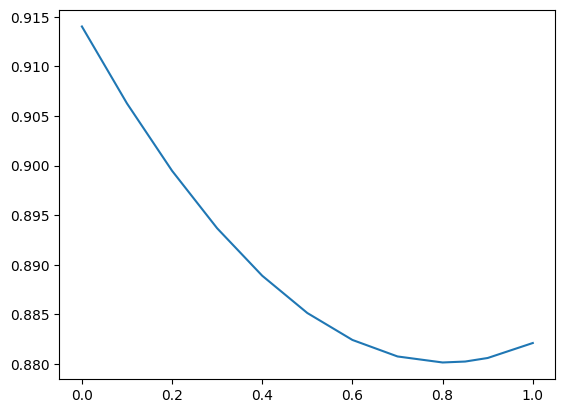

In [ ]:
import matplotlib.pyplot as plt
x = np.array(x)
y = np.array(y)
plt.plot(x,y)

всё deepfm не вышло

In [ ]:
# сочетание явных и неявных функций взаимодействий для систем рекомендации
# linear_feature_columns – Итерационная таблица, содержащая все функции,
#  используемые линейной частью модели.
# dnn_feature_columns – Повторяемая таблица, 
# содержащая все функции, используемые глубинной частью модели.

my_model = DeepFM(item_features,item_features) #movielens['item_labels']
my_model.compile()
my_model.fit(train)
# import tensorflow as tf



# from deep_recommenders.keras.models.ranking import DeepFM

TypeError: ignored

In [ ]:
item_features